In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [1]:
from pmdarima import auto_arima

In [3]:
inv = pd.read_json('jsonraw/inv.json')
offline = pd.read_json('jsonraw/offline.json')
time = pd.read_json('jsonraw/time.json')
visit = pd.read_json('jsonraw/visit.json')
web = pd.read_json('jsonraw/web.json')


In [4]:

# Organizar los DataFrames en un diccionario para facilitar el análisis
dataframes = {
    'inv': inv,
    'offline': offline,
    'time': time,
    'visit': visit,
    'web': web
}

# Recorrer cada DataFrame y mostrar información relevante
for name, df in dataframes.items():
    print(f"\nDataFrame: {name}")
    print("-" * 40)
    # Mostrar forma (número de filas y columnas)
    print("Shape:", df.shape)
    # Mostrar nombres de columnas
    print("Columns:", df.columns.tolist())
    
    # Mostrar las primeras 5 filas para ver un ejemplo de los datos
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Mostrar información general (tipos de datos, non-null count, etc.)
    print("\nData Info:")
    df.info()
    
    # Mostrar estadísticas descriptivas (solo para columnas numéricas)
    print("\nDescriptive Statistics:")
    print(df.describe())
    
    # Mostrar la cantidad de valores faltantes en cada columna
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    print("=" * 80)


DataFrame: inv
----------------------------------------
Shape: (36, 11)
Columns: ['ID_Date', 'CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION', 'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS', 'INV_Total']

First 5 rows:
   ID_Date      CINE  EXTERIOR   INTERNET   PRENSA  PRODUCCION      RADIO  \
0   202201  59887.84   8200.00  133666.43      0.0      6050.0    2426.40   
1   202202  72291.56  94627.51  189275.94  10000.0      6700.0       0.00   
2   202203  55000.00      0.00  214037.62   4500.0      3700.0       0.00   
3   202204  10883.30      0.00  194816.97  48800.0     21550.0    1140.00   
4   202205  74333.20      0.00  130795.16  11000.0      4900.0  102851.86   

   REVISTAS  PlataformasVideo    VARIOS  INV_Total  
0  18013.50         338824.94   7531.03  574600.14  
1  49110.91         487537.14   6972.02  916515.08  
2      0.00          75000.00  15284.85  367522.47  
3  40876.00         610865.89  12255.75  941187.91  
4  20775.75         393807.74   7926.46  74

In [5]:
# Merge the DataFrames one by one on the 'ID_Date' column
df_merged = inv.merge(offline, on='ID_Date', how='inner') \
               .merge(time, on='ID_Date', how='inner') \
               .merge(visit, on='ID_Date', how='inner') \
               .merge(web, on='ID_Date', how='inner')

# Optionally, sort the merged DataFrame by ID_Date
df_merged = df_merged.sort_values('ID_Date')

# Display the first few rows and shape of the merged DataFrame
print(df_merged.head())
print("Merged DataFrame shape:", df_merged.shape)

   ID_Date      CINE  EXTERIOR   INTERNET   PRENSA  PRODUCCION      RADIO  \
0   202201  59887.84   8200.00  133666.43      0.0      6050.0    2426.40   
1   202202  72291.56  94627.51  189275.94  10000.0      6700.0       0.00   
2   202203  55000.00      0.00  214037.62   4500.0      3700.0       0.00   
3   202204  10883.30      0.00  194816.97  48800.0     21550.0    1140.00   
4   202205  74333.20      0.00  130795.16  11000.0      4900.0  102851.86   

   REVISTAS  PlataformasVideo    VARIOS  ...  PDFBrochuresDownloaded  \
0  18013.50         338824.94   7531.03  ...                    4838   
1  49110.91         487537.14   6972.02  ...                    5823   
2      0.00          75000.00  15284.85  ...                    4845   
3  40876.00         610865.89  12255.75  ...                    3711   
4  20775.75         393807.74   7926.46  ...                    9037   

   ProductConfigurator  Product_configurator_Visists  SocialNetworks  \
0                33222          

In [6]:
# Assuming your merged DataFrame (from previous merge) is stored in df_merged
# Convert the 'ID_Date' column from numeric (e.g., 202201) to datetime using the format '%Y%m'
df_merged['ID_Date'] = pd.to_datetime(df_merged['ID_Date'].astype(str), format='%Y%m')
df_merged.set_index('ID_Date', inplace=True)
df_merged.sort_index(inplace=True)

# Display the first few rows to verify the datetime index
print(df_merged.head())

                CINE  EXTERIOR   INTERNET   PRENSA  PRODUCCION      RADIO  \
ID_Date                                                                     
2022-01-01  59887.84   8200.00  133666.43      0.0      6050.0    2426.40   
2022-02-01  72291.56  94627.51  189275.94  10000.0      6700.0       0.00   
2022-03-01  55000.00      0.00  214037.62   4500.0      3700.0       0.00   
2022-04-01  10883.30      0.00  194816.97  48800.0     21550.0    1140.00   
2022-05-01  74333.20      0.00  130795.16  11000.0      4900.0  102851.86   

            REVISTAS  PlataformasVideo    VARIOS  INV_Total  ...  \
ID_Date                                                      ...   
2022-01-01  18013.50         338824.94   7531.03  574600.14  ...   
2022-02-01  49110.91         487537.14   6972.02  916515.08  ...   
2022-03-01      0.00          75000.00  15284.85  367522.47  ...   
2022-04-01  40876.00         610865.89  12255.75  941187.91  ...   
2022-05-01  20775.75         393807.74   7926.46  74

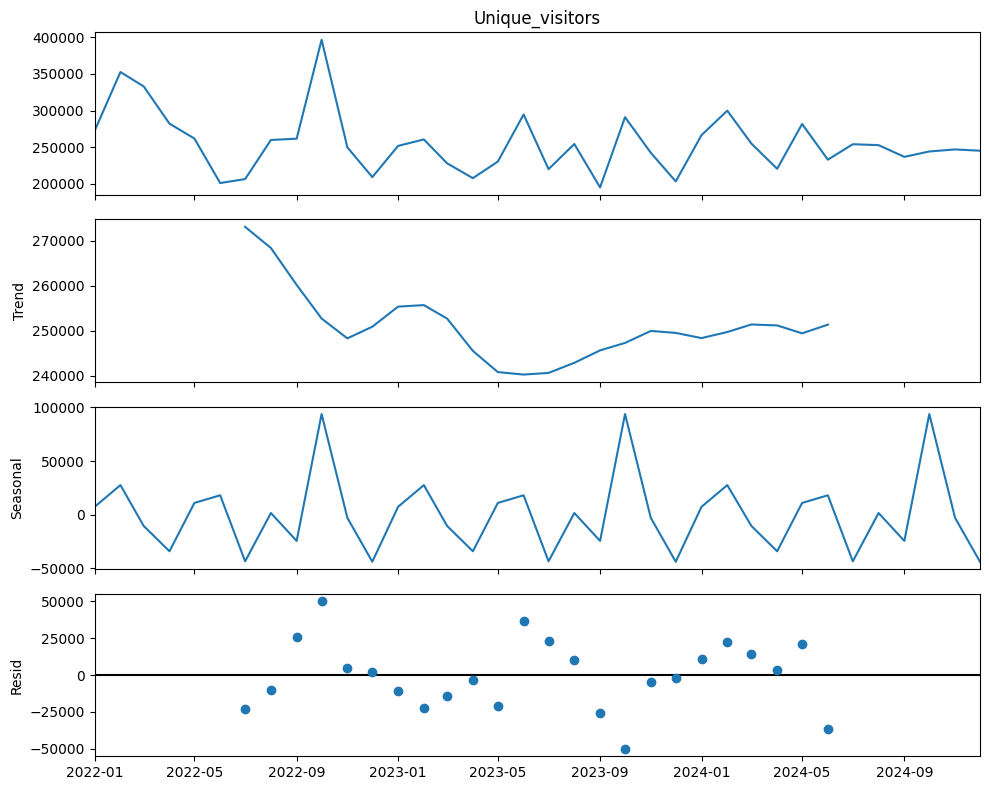

In [12]:

# Perform seasonal decomposition on the 'Unique_visitors' column.
# We use an additive model assuming that the seasonal variations are roughly constant.
# For monthly data with yearly seasonality, period is set to 12.
decomposition = seasonal_decompose(df_merged['Unique_visitors'], model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

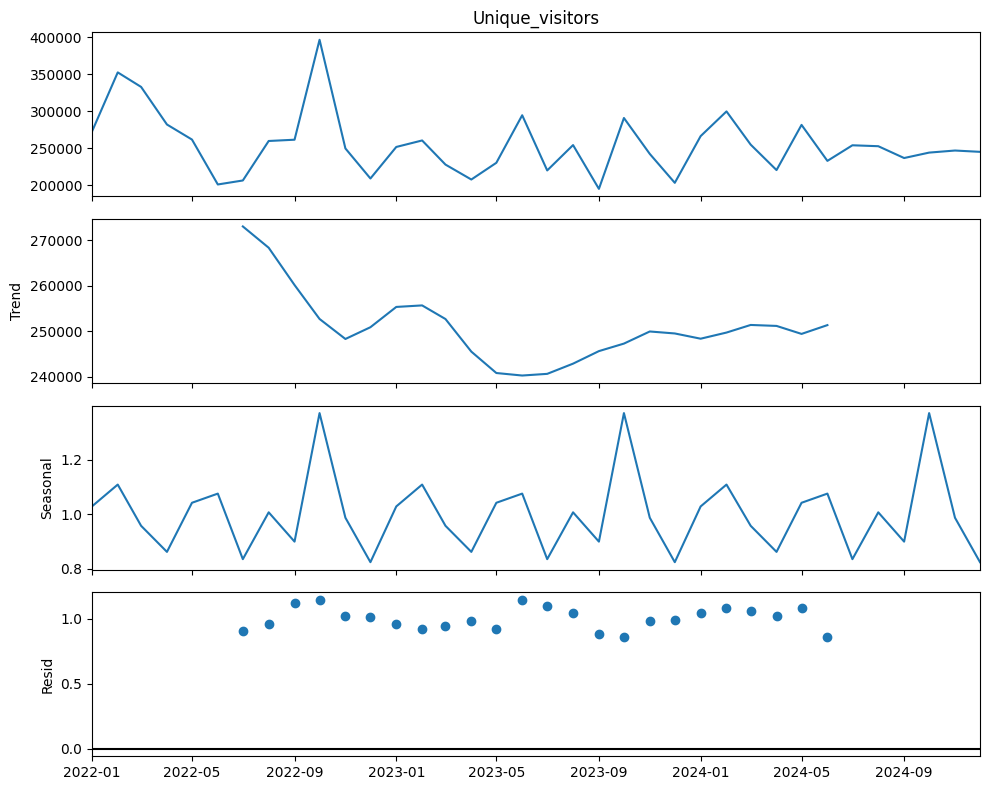

In [29]:
decomposition = seasonal_decompose(df_merged['Unique_visitors'], model='multiplicative', period=12)


trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid


# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()


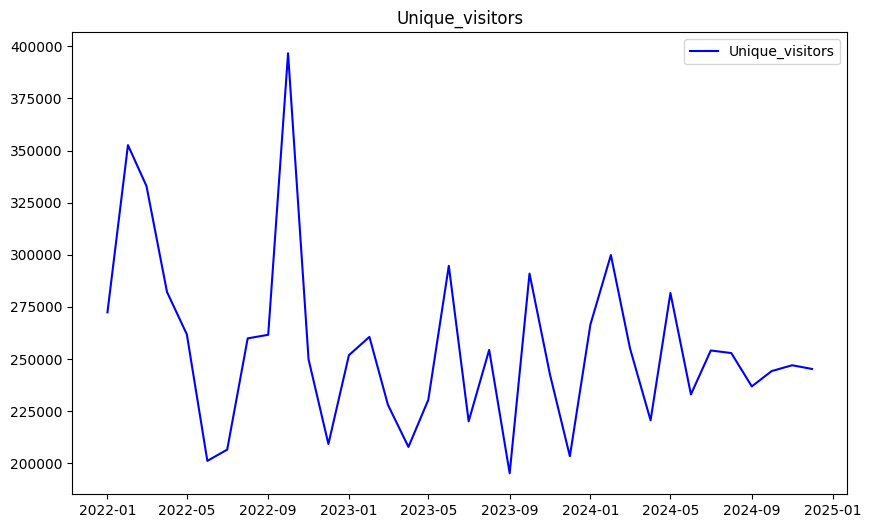

In [13]:
# show df merged using pyplot

plt.figure(figsize=(10, 6))
plt.plot(df_merged['Unique_visitors'], label='Unique_visitors', color='blue')
plt.title('Unique_visitors')
plt.legend()
plt.show()

In [15]:
df_merged.to_json('jsonclean/fulldata.json')

In [ ]:
# Apply auto_arima to the "Unique_visitors" column
# Since the data is monthly, we set m=12 to account for yearly seasonality.
stepwise_model = auto_arima(
    df_merged['Unique_visitors'],
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    d=1,           # order of non-seasonal differencing
    seasonal=True,
    m=6,          # seasonal period (6 months)
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    D=1,           # order of seasonal differencing
    trace=True,    # display the search process
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


In [ ]:
# Print the summary of the best model found
print(stepwise_model.summary())

# Forecast the next 6 periods (months)
n_periods = 6
forecast = stepwise_model.predict(n_periods=n_periods)

# Create a date range for the forecast starting after the last date in the original series
forecast_index = pd.date_range(start=df_merged.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

# Convert the forecast into a pandas Series for plotting
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the historical "Unique_visitors" data and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_merged['Unique_visitors'], label='Historical')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Forecast of Unique Visitors')
plt.xlabel('Date')
plt.ylabel('Unique Visitors')
plt.legend()
plt.show()